In [1]:
from matplotlib import pyplot as plt
import numpy as np
import classifier_utils
from classifier_utils import cnn_model, preprocess_img, get_class
%matplotlib inline
import glob
import os
from skimage import io
from skimage import transform
import keras
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.models import Sequential, Model
import vgg16


Using TensorFlow backend.


## Loading CIFAR10

In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
print y_train[1] 

### Array details (dimension, type):

In [ ]:
print x_train.shape

In [ ]:
type(x_train)

In [ ]:
print x_train

### Image resizing. Vgg16 takes minimum size of 48x48

In [3]:
x_train_vgg = np.zeros((50000,64,64,3))

for i in range(50000):
    x_train_vgg[i] = transform.resize(x_train[i], (64, 64), order=0)

/home/pas_user/anaconda2/envs/tensor_virtenv/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
#1st model
#IMG_SIZE = 32
#2nd model
IMG_SIZE = 64 
NUM_CLASSES = 10

### Reducing amount of pictures

In [ ]:
#1st model
x_train = x_train[0:5000]
y_train = y_train[0:5000]

In [20]:
#print categories .count
for i in len(y_train):
    print i

TypeError: 'int' object is not iterable

In [5]:
#2nd model
x_train_vgg = x_train_vgg[0:5000]
y_train_vgg = y_train[0:5000]

In [6]:
print x_train_vgg.shape

(5000, 64, 64, 3)


In [ ]:
x_train = x_train.astype('float32')/255 # now values are between 0 and 1

### Why already calculated values? By default on .resize

In [7]:
print x_train_vgg

[[[[ 0.23137255  0.24313725  0.24705882]
   [ 0.23137255  0.24313725  0.24705882]
   [ 0.16862745  0.18039216  0.17647059]
   ..., 
   [ 0.59607843  0.49019608  0.4       ]
   [ 0.58039216  0.48627451  0.40392157]
   [ 0.58039216  0.48627451  0.40392157]]

  [[ 0.23137255  0.24313725  0.24705882]
   [ 0.23137255  0.24313725  0.24705882]
   [ 0.16862745  0.18039216  0.17647059]
   ..., 
   [ 0.59607843  0.49019608  0.4       ]
   [ 0.58039216  0.48627451  0.40392157]
   [ 0.58039216  0.48627451  0.40392157]]

  [[ 0.0627451   0.07843137  0.07843137]
   [ 0.0627451   0.07843137  0.07843137]
   [ 0.          0.          0.        ]
   ..., 
   [ 0.46666667  0.3254902   0.19607843]
   [ 0.47843137  0.34117647  0.22352941]
   [ 0.47843137  0.34117647  0.22352941]]

  ..., 
  [[ 0.70588235  0.54509804  0.37647059]
   [ 0.70588235  0.54509804  0.37647059]
   [ 0.67843137  0.48235294  0.16470588]
   ..., 
   [ 0.38039216  0.24313725  0.13333333]
   [ 0.3254902   0.20784314  0.13333333]
   [ 0.

### Examples from training set (64x64 and 32x32)

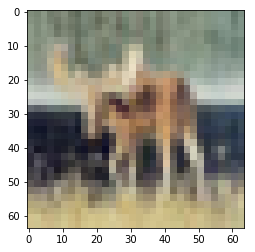

In [33]:
single_image = x_train_vgg[28:29]
plt.imshow(single_image[0])         

In [ ]:
single_image = x_train[300:301]
plt.imshow(single_image[0])   

### Zdjecie warstwy: include_top=False

In [ ]:
#first_model = cnn_model(IMG_SIZE,NUM_CLASSES)

In [9]:
second_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(64,64,3), pooling=max)

### Choose model (remember to set NUM_CLASSES)

In [10]:
#model = first_model
model = second_model

In [11]:
model.layers

### Freezing layers (for VGG16 additional layer, all previous layers need to be frozen)

In [12]:
for layer in model.layers: layer.trainable=False

### Alternative way to add last layer and activation 

In [13]:
#model.add(Dense(NUM_CLASSES, activation='softmax')) .add doesn't work for VGG16

last = model.output

x = Flatten()(last)
preds = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(model.input, preds)

In [14]:
model.layers

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [16]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#1st model
#model.fit(x_train, y_train, batch_size=128, epochs=10)
#2nd model
model.fit(x_train_vgg, y_train_vgg, batch_size=128, epochs=10)

Epoch 1/10
5000/5000 [==============================] - 128s - loss: 0.6628 - acc: 0.7994   
Epoch 2/10
5000/5000 [==============================] - 126s - loss: 0.6497 - acc: 0.8066   
Epoch 3/10
5000/5000 [==============================] - 125s - loss: 0.6392 - acc: 0.8096   
Epoch 4/10
5000/5000 [==============================] - 126s - loss: 0.6248 - acc: 0.8144   
Epoch 5/10
5000/5000 [==============================] - 126s - loss: 0.6152 - acc: 0.8160   
Epoch 6/10
5000/5000 [==============================] - 126s - loss: 0.6054 - acc: 0.8236   
Epoch 7/10
5000/5000 [==============================] - 126s - loss: 0.5972 - acc: 0.8270   
Epoch 8/10
5000/5000 [==============================] - 125s - loss: 0.5877 - acc: 0.8240   
Epoch 9/10
5000/5000 [==============================] - 126s - loss: 0.5814 - acc: 0.8316   
Epoch 10/10
3456/5000 [===================>..........] - ETA: 39s - loss: 0.5793 - acc: 0.8325

### Set test size to 64x64

In [ ]:
model.evaluate(x_test, y_test)